# Fit any function with single qubit

## 1. import packages

Noted that backend should be set to 'state_vector'

In [1]:
import os
os.environ['PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION'] = 'python'

In [2]:
import paddle
import numpy as np
import paddle_quantum
from paddle_quantum.ansatz import Circuit
from paddle_quantum.hamiltonian import Hamiltonian
from paddle_quantum.loss import ExpecVal
import matplotlib.pyplot as plt
import matplotlib

paddle_quantum.set_backend("state_vector")

C:\Users\ThinkPad\AppData\Roaming\Python\Python39\site-packages\urllib3\util\selectors.py:14: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import namedtuple, Mapping
C:\Users\ThinkPad\AppData\Roaming\Python\Python39\site-packages\urllib3\_collections.py:2: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import Mapping, MutableMapping
C:\Users\ThinkPad\AppData\Roaming\Python\Python39\site-packages\openfermion\hamiltonians\hartree_fock.py:11: DeprecationWarning: Please use `OptimizeResult` from the `scipy.optimize` namespace, the `scipy.optimize.optimize` namespace is deprecated.
  from scipy.optimize.optimize import OptimizeResult
C:\Users\ThinkPad\AppData\Roaming\Python\Python39\site-packages\paddle\tensor\creatio

# 2. Some theory 

We want our ciruit be able to fit a group of data $\{x_i,f(x_i)\}$.

For each $x_i$, we construct a unitary gate:

$  U_ {\theta ,\phi ,L}^ {WZW}  (x_i)= R_ {Y}  (  \theta _ {0}  )  R_ {Z}  ( \phi _ {0}  )  \sum _ {j=1}^ {L}  R_ {Z}  (x_i) R_ {Y}  (  \theta _ {j})R_{Z}  (  \phi _ {j}  ) $

where $\theta$ and $\phi$ are parameters to be trained, $L$ is the depth of the circuit .

Let depth = 2, the circuit looks like:

![](https://github.com/tzajack/QuantumLearning/blob/main/SingleQubitQNN/appendix/single1.PNG?raw=true)

The expectation $\langle 0 | U_ {\theta ,\phi ,L}^ {WZW}  (x_i) | 0 \rangle$ is the Fourier series $a_0+\Sigma^{L}_{j=1}(a_j\cos(nx) + b_j \sin(nx))$ so it can fit any $f:[-\pi,\pi]\rightarrow [-1,1]$ 

In [3]:
def U_WZW(train_block, w_theta, x):
    cir = Circuit(1)
    #Add part of the circuit equivlant to the summation part 
    for i in range(train_block):
        cir.rz(0, param=w_theta[i][1])
        cir.ry(0, param=w_theta[i][0])
        cir.rz(0, param=x) 
    #Add the first Ry,Rz
    cir.rz(0, param=w_theta[-1][1])
    cir.ry(0, param=w_theta[-1][0])
    return cir

## 3. Model define and train 

As ususal, we use Pauli $\langle Z \rangle$ for observation.

We add a scaling coefficient and bias to be train so the range of our fit function is wider.

The final output is $\hat{y} = coeff\langle Z \rangle+bias$

In [4]:
class QNN(paddle.nn.Layer):
    def __init__(self, 
                 train_block,          
                 SEED=0,
                 dtype='float64'):
        super(QNN, self).__init__()
        self.train_block = train_block
        paddle.seed(SEED)
        self.coeff  = self.create_parameter(
            shape=[1],
            default_initializer=paddle.nn.initializer.Normal(std=0.01),
            dtype='float64',
            is_bias=False)
        self.bias = self.create_parameter(
            shape=[1],
            default_initializer=paddle.nn.initializer.Normal(std=0.01),
            dtype='float64',
            is_bias=False)
        self.w_theta = self.create_parameter(
            shape=[(train_block+1), 2],
            default_initializer=paddle.nn.initializer.Uniform(0.0, 2*np.pi),
            dtype=dtype,
            is_bias=False)


    def forward(self, x):
        predict = []
        H = Hamiltonian([(1.0, "z0")])
        out_func = ExpecVal(H)
        x = paddle.to_tensor(x, dtype='float64')
        if len(x.shape) == 1:  
            x = x.reshape((-1, 1))
        for i in range(x.shape[0]):
            cir = U_WZW(self.train_block, self.w_theta, x[i])
            out_state = cir()
            out_val = out_func(out_state)*self.coeff + self.bias
            predict.append(out_val)
        
        return paddle.concat(predict).reshape((-1,)), cir

Usual ML training function 

In [5]:
def train_qnn(x, y, train_block, LR , Epoch,SEED, BATCHSIZE):
    model = QNN(train_block, SEED)
    opt = paddle.optimizer.Adam(learning_rate=LR, parameters=model.parameters())
    loss_list = []
    x = paddle.to_tensor(x, dtype='float64')
    y = paddle.to_tensor(y, dtype='float64')
    for ep in range(1, Epoch + 1):
        for itr in range(len(x) // BATCHSIZE):
            l = itr*BATCHSIZE
            r = min( (itr + 1) * BATCHSIZE , len(x) )
            x_batch = x[l:r]
            y_batch = y[l:r]
            predict, cir = model(x_batch)
            avg_loss = paddle.mean((predict - y_batch) ** 2)
            loss_list.append(avg_loss.numpy())
            avg_loss.backward()
            opt.minimize(avg_loss)
            opt.clear_grad()
            
        print("qnn:epoch:", ep, " train  loss:", "%.5f" % avg_loss.numpy())


    return model, loss_list

## 4. Test the model

We choose $f(x) = x^2,\sin x,e^x$ as examples

We generate $100$ test and train data points over $[-1,1]$


In [6]:
def target_func(x):
    return x**2


def get_data():
    x_plot = np.arange(-1, 1, 5/1000)
    y_plot = target_func(x_plot)

    np.random.seed(0)
    x_all = np.random.uniform(-1, 1, 200)

    y_all = target_func(x_all)

    x_train, y_train = x_all[:100], y_all[:100]
    x_test,y_test = x_all[100:], y_all[100:]

    return x_train, y_train,x_test,y_test, x_plot, y_plot


x_train, y_train, x_test,y_test,x_plot, y_plot = get_data()

Fix the depth of the circuit to be $10$

Try $f(x)=x^2$ first

C:\Users\ThinkPad\AppData\Roaming\Python\Python39\site-packages\paddle\fluid\framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
C:\Users\ThinkPad\AppData\Roaming\Python\Python39\site-packages\paddle\fluid\dygraph\math_op_patch.py:276: UserWarning: The dtype of left and right variables are not the same, left dtype is paddle.float32, but right dtype is paddle.float64, the right dtype will convert to paddle.float32
  warnings.warn(


qnn:epoch: 1  train  loss: 0.09176
qnn:epoch: 2  train  loss: 0.02994
qnn:epoch: 3  train  loss: 0.01711
qnn:epoch: 4  train  loss: 0.01239
qnn:epoch: 5  train  loss: 0.00147
qnn:epoch: 6  train  loss: 0.00537
qnn:epoch: 7  train  loss: 0.00118
qnn:epoch: 8  train  loss: 0.00296
qnn:epoch: 9  train  loss: 0.00146
qnn:epoch: 10  train  loss: 0.00073


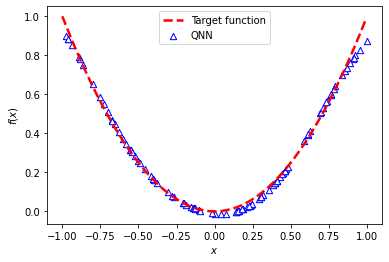

In [7]:
def target_func(x):
    return x**2
x_train, y_train, x_test,y_test,x_plot, y_plot = get_data()
SEED = 2
Epoch = 10
LR = 0.1
train_block = 10
bs = 16
model, loss_list = train_qnn(x_train, y_train, train_block=train_block, LR=LR, Epoch=Epoch, SEED=SEED,BATCHSIZE=bs)
predict = model(x_test)
plt.plot(x_plot, y_plot, color="r", ls="--", lw=2.5, label="Target function")
plt.scatter(
        x_test,
        predict[0].numpy(),
        s=40,
        marker="^",
        facecolor="white",
        color="b",
        label="QNN",
    )
plt.xlabel(r"$x$")
plt.ylabel(r"$f(x)$")
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend()
plt.show()

Then $f(x)=\sin x$

C:\Users\ThinkPad\AppData\Roaming\Python\Python39\site-packages\paddle\tensor\creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if data.dtype == np.object:
C:\Users\ThinkPad\AppData\Roaming\Python\Python39\site-packages\paddle\fluid\framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
C:\Users\ThinkPad\AppData\Roaming\Python\Python39\site-packages\paddle\fluid\dyg

qnn:epoch: 1  train  loss: 0.04530
qnn:epoch: 2  train  loss: 0.01109
qnn:epoch: 3  train  loss: 0.00205
qnn:epoch: 4  train  loss: 0.00532
qnn:epoch: 5  train  loss: 0.00233
qnn:epoch: 6  train  loss: 0.00238
qnn:epoch: 7  train  loss: 0.00420
qnn:epoch: 8  train  loss: 0.00199
qnn:epoch: 9  train  loss: 0.00212
qnn:epoch: 10  train  loss: 0.00010


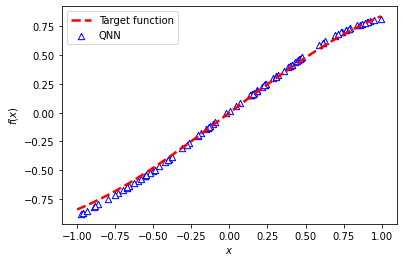

In [8]:
def target_func(x):
    return np.sin(x)
x_train, y_train, x_test,y_test,x_plot, y_plot = get_data()
SEED = 2
Epoch = 10
LR = 0.1
train_block = 10
bs = 16
model, loss_list = train_qnn(x_train, y_train, train_block=train_block, LR=LR, Epoch=Epoch, SEED=SEED,BATCHSIZE=bs)
predict = model(x_test)
plt.plot(x_plot, y_plot, color="r", ls="--", lw=2.5, label="Target function")
plt.scatter(
        x_test,
        predict[0].numpy(),
        s=40,
        marker="^",
        facecolor="white",
        color="b",
        label="QNN",
    )
plt.xlabel(r"$x$")
plt.ylabel(r"$f(x)$")
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend()
plt.show()

Finally, $f(x)=e^x$

C:\Users\ThinkPad\AppData\Roaming\Python\Python39\site-packages\paddle\tensor\creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if data.dtype == np.object:
C:\Users\ThinkPad\AppData\Roaming\Python\Python39\site-packages\paddle\fluid\framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
C:\Users\ThinkPad\AppData\Roaming\Python\Python39\site-packages\paddle\fluid\dyg

qnn:epoch: 1  train  loss: 0.47626
qnn:epoch: 2  train  loss: 0.11292
qnn:epoch: 3  train  loss: 0.03071
qnn:epoch: 4  train  loss: 0.01417
qnn:epoch: 5  train  loss: 0.02957
qnn:epoch: 6  train  loss: 0.00271
qnn:epoch: 7  train  loss: 0.00695
qnn:epoch: 8  train  loss: 0.03423
qnn:epoch: 9  train  loss: 0.03588
qnn:epoch: 10  train  loss: 0.00446


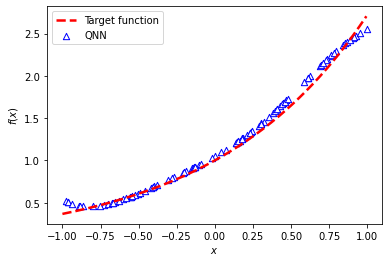

In [9]:
def target_func(x):
    return np.exp(x)
x_train, y_train, x_test,y_test,x_plot, y_plot = get_data()
SEED = 2
Epoch = 10
LR = 0.1
train_block = 10
bs = 16
model, loss_list = train_qnn(x_train, y_train, train_block=train_block, LR=LR, Epoch=Epoch, SEED=SEED,BATCHSIZE=bs)
predict = model(x_test)
plt.plot(x_plot, y_plot, color="r", ls="--", lw=2.5, label="Target function")
plt.scatter(
        x_test,
        predict[0].numpy(),
        s=40,
        marker="^",
        facecolor="white",
        color="b",
        label="QNN",
    )
plt.xlabel(r"$x$")
plt.ylabel(r"$f(x)$")
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend()
plt.show()